In [54]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import holoviews as hv
from scipy.ndimage.filters import gaussian_filter1d as gf1d

In [10]:
hv.notebook_extension()

In [2]:
pi = np.pi
twopi = 2 * pi
atan = np.arctan
ln = np.log
mu0 = 4e-7 * np.pi

In [3]:
def By_surface(x, w, d, j):
    """Magnetic field directed perpendicular to the
    surface of a conducting slab at the slabs surface,
    uniform current:
    
    Field at this top surface along +y (up)
    
         -----------------------------  y = d/2
         |                           |  
         |             Slab          | y = 0
         |                           |
         ----------------------------- y = -d/2
      x = -w/2        x = 0        x = w/2
      
    ^+y
    |
    |
    ---->+x
    
    z out of monitor towards keyboard
    
    Current density is uniform and along +z
    
    Arguments:
        x (float): coordinate where field is computed (meters)
        w (float): width of slab in x direction (meters).
        d (float): depth of slab in y direction (meters).
        j (float): current density in slab (Amps/meters**2)
        
    Returns:
        By (float): Magnetic field at x (Tesla).
    """
    A = w - 2*x
    B = w + 2*x
    C = 2*d
    mu0_over_4pi = 1e-7
    return mu0_over_4pi * j * (-A * np.arctan(C / A) + 
                               B * np.arctan(C / B) + 
                               C/2 * np.log((B**2 + C**2) / (A**2 + C**2)))

def By_arb(x, y, w, d, j):
    """Magnetic field directed perpendicular to the
    surface of a conducting slab at an arbitrary point
    in the slab:
    
    Field at this point (the 'o') along +y (up)
              | 
              v    
         -----------------------------  y = d/2
         |    o                      |  
         |             Slab          | y = 0
         |                           |
         ----------------------------- y = -d/2
      x = -w/2        x = 0        x = w/2
      
    ^+y
    |
    |
    ---->+x
    
    z out of monitor towards keyboard
    
    Current density is uniform and along +z
    
    Arguments:
        x (float): x coordinate where field is computed (meters).
        y (float): y coordinate where the field is computed (meters).
        w (float): width of slab in x direction (meters).
        d (float): depth of slab in y direction (meters).
        j (float): current density in slab (Amps/meters**2)
        
    Returns:
        By (float): Magnetic field at x (Tesla).
    """
    A = w - 2*x
    B = w + 2*x
    C = 2*d
    D = d - 2*y
    E = d + 2*y
    mu0_over_4pi = 1e-7
    atan = np.arctan
    ln = np.log
    return -mu0_over_4pi * j * (
          -A * (atan(D/A) + atan(E/A))
        +  B * (atan(E/B) + atan(D/B))
        +  y * ln((B**2 + D**2) * (A**2 + E**2) / (B**2 + E**2) / (A**2 + D**2))
        + d/2* ln((A**2 + E**2) * (A**2 + D**2) / (B**2 + D**2) / (B**2 + E**2))
    )
    

def By_2d_approximation(x, w, d, j):
    mu0_over_4pi = 1e-7
    return 2e-7 * j * d * np.log((w/2 + x) / (w/2 - x))

def g2d(x, y, x0, y0, beam_fwhm):
    """2d Gaussian function.
    Parameters:
        x (float): x coordinate
        y (float): y coordinate
        x0 (float): Center in x direction
        y0 (float): Center in y direction
        beam_fwhm: Full width half max of beam. Equal to 2.3548 of std_dev
    """
    s = beam_fwhm / 2.3548
    return 1/(twopi * s**2) * np.exp(-((x - x0)**2 + (y - y0)**2)/(2*s**2))

def g1d(x, x0, beam_fwhm):
    """1d Gaussian centered at x0 and with FWHM beam_fwhm."""
    s = beam_fwhm / 2.3548
    return twopi**-0.5 / s * np.exp(-(x - x0)**2/(2*s**2))

def box1d(x, x0, d):
    return (abs(x - x0) <=d).astype(int)

def circmask(N, asint=True, rmax=None):
    """A circular mask centered at the array center.
    For example N=5:
    [[ 0.  1.  1.  1.  0.]
     [ 1.  1.  1.  1.  1.]
     [ 1.  1.  1.  1.  1.]
     [ 1.  1.  1.  1.  1.]
     [ 0.  1.  1.  1.  0.]]
    """
    x, y = np.ogrid[:N,:N]
    if N % 2 == 1:
        c = N//2
    else:
        c = N//2 - 0.5
    r2 = (x-c)**2 + (y-c)**2
    if rmax is None:
        rmax = N/2
    m = r2 <= rmax**2
    if asint:
        return m.astype(int)
    else:
        return m

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in log


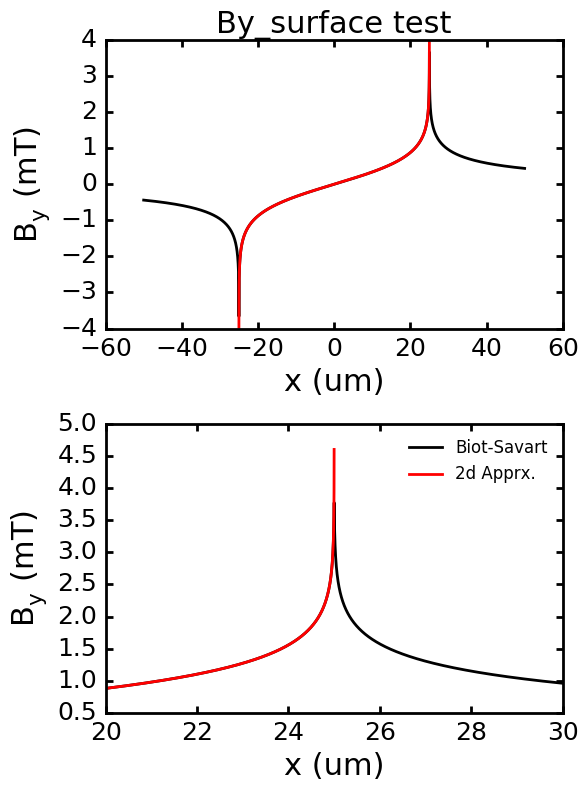

In [4]:
# Test By_surface and compare to By_2d_approximation

w = 50e-6
d = 10e-9
j = 0.1 / (w * d)
x = np.linspace(-w, w, 10000)
By = By_surface(x, w, d, j)
By_apprx = By_2d_approximation(x, w, d, j)

fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(6, 8))
ax.set_xlabel('x (um)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)
ax2.set_xlabel('x (um)', fontsize=22)
ax2.set_ylabel('B$_y$ (mT)', fontsize=22)

ax.plot(1e6 * x, 1000 * By, 'k-', label='Biot-Savart')
ax.plot(1e6 * x, 1000 * By_apprx, 'r-', label='2d Apprx.')

x = np.linspace(0.4*w, 0.6*w, 10000)
By = By_surface(x, w, d, j)
By_apprx = By_2d_approximation(x, w, d, j)
ax2.plot(1e6 * x, 1000 * By, 'k-', label='Biot-Savart')
ax2.plot(1e6 * x, 1000 * By_apprx, 'r-', label='2d Apprx.')

plt.legend(loc='best')
ax.set_title('By_surface test', fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

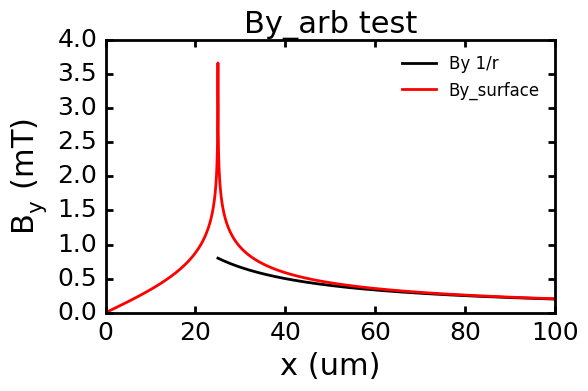

In [5]:
# Test By by comparing to 1/r outside of conductor

w = 50e-6
d = 10e-9
j = 0.1 / (w * d)
x = np.linspace(0, 2 * w, 10000)
y = d/2
By_s = By_surface(x, w, d, j)

xout = np.linspace(w/2, 2 * w, 5000)
By_outside = 2e-7 * j * w * d / (xout - d/2)

fig, ax = plt.subplots(nrows=1, figsize=(6, 4))
ax.set_xlabel('x (um)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)

ax.plot(1e6 * xout, 1000 * By_outside, 'k-', label='By 1/r')
ax.plot(1e6 * x, 1000 * By_s, 'r-', label='By_surface')

plt.legend(loc='best')
ax.set_title('By_arb test', fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:93: RuntimeWarning: invalid value encountered in log


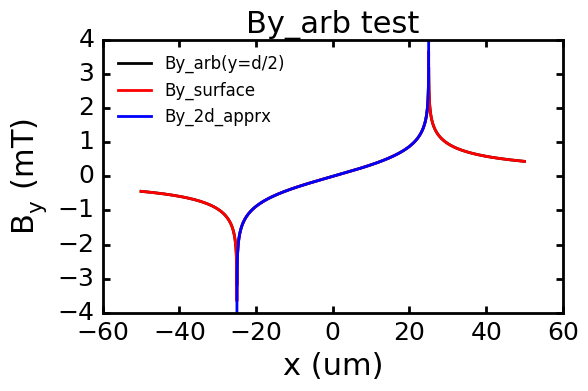

In [6]:
# Test By by comparing to By_surface

w = 50e-6
d = 10e-9
j = 0.1 / (w * d)
x = np.linspace(-w, w, 10000)
y = d/2
By = By_arb(x, y, w, d, j)
By_s = By_surface(x, w, d, j)
By_apprx = By_2d_approximation(x, w, d, j)

fig, ax = plt.subplots(nrows=1, figsize=(6, 4))
ax.set_xlabel('x (um)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)

ax.plot(1e6 * x, 1000 * By, 'k-', label='By_arb(y=d/2)')
ax.plot(1e6 * x, 1000 * By_s, 'r-', label='By_surface')
ax.plot(1e6 * x, 1000 * By_apprx, 'b-', label='By_2d_apprx')

plt.legend(loc='best')
ax.set_title('By_arb test', fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

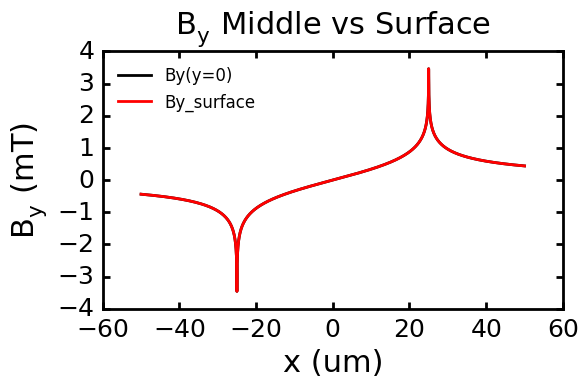

In [7]:
# Compare By(middle) By(surface)

w = 50e-6
d = 10e-9
j = 0.1/(w * d)
x = np.linspace(-w, w, 10000)
y = 0

By_middle = By_arb(x, y, w, d, j)
By_s = By_arb(x, 0.0, w, d, j)

fig, ax = plt.subplots(nrows=1, figsize=(6, 4))
ax.set_xlabel('x (um)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)
ax.plot(1e6 * x, 1000 * By_middle, 'k-', label='By(y=0)')
ax.plot(1e6 * x, 1000 * By_s, 'r-', label='By_surface')

plt.legend(loc='best')
ax.set_title(r'B$_{y}$ Middle vs Surface', fontsize=22, y=1.04)
plt.tight_layout()
plt.show()
plt.close()

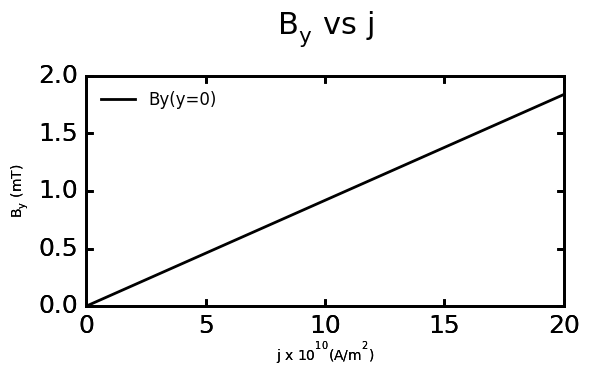

In [85]:
# Look at Current Density Dependence

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

w = 50e-6
d = 10e-9
j = np.array(list(i/(w * d) for i in (0.0, 0.01, 0.025, 0.05, 0.075, 0.1)))
x = w/2 - w/100
y = d/2

By_middle = By_arb(x, y, w, d, j)

ax = host_subplot(111, axes_class=AA.Axes)
# ax2 = ax.twin()
# ax2.set_xticks(w * d * jticks)
# ax2.set_xticklabels()
# ax2.axis["right"].major_ticklabels.set_visible(False)
ax.plot(j/1e10, 1000 * By_middle, 'k-', label='By(y=0)')
jticks = ax.get_xticks()



plt.legend(loc='best')
ax.set_title(r'B$_{y}$ vs j', fontsize=22, y=1.15)
ax.set_xlabel(r'j x 10$^{10}$(A/m$^2$)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

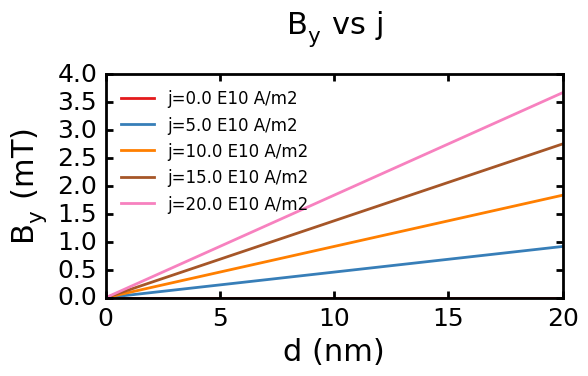

In [8]:
# Look at Current Density Dependence

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

w = 50e-6
d = np.array(list((0, 5e-9, 10e-9, 15e-9, 20e-9)))
j = 20e10
x = w/2 - w/100
y = d/2



fig, ax = plt.subplots()

for j in (0, 5e10, 10e10, 15e10, 20e10):
    By_middle = By_arb(x, y, w, d, j)
    ax.plot(d * 1e9, 1000 * By_middle, '-', label='j=%.1f E10 A/m2'%(j/1e10))

plt.legend(loc='best')
ax.set_title(r'B$_{y}$ vs j', fontsize=22, y=1.15)
ax.set_xlabel(r'd (nm)', fontsize=22)
ax.set_ylabel('B$_y$ (mT)', fontsize=22)
plt.tight_layout()
plt.show()
plt.close()

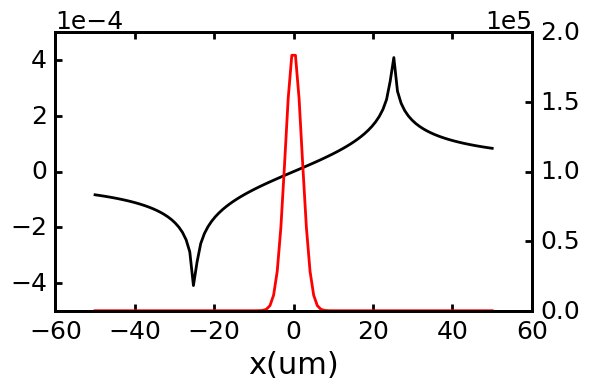

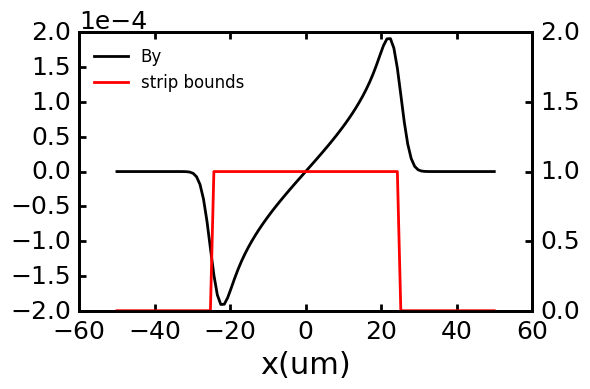

In [55]:
# Test gaussian smoothing of By_surface

w = 50e-6
d = 2.5e-9
I_py_layer = 0.019  # Amps
j = I_py_layer / (w * d)
dmy_per_By = 1.0  # Coincidentally Hshape = u0 Ms(py) = 1 Tesla so this 1.0 is correct!
polrot_per_detectorV = 1.0
beam_fwhm = 5e-6
x = np.linspace(-w, w, 110)
xum = 1e6 * x
By = By_surface(x, w, d, j)
beam_intens = g1d(x, 0, beam_fwhm)
above_strip = box1d(x, 0, w/2)

fig, ax = plt.subplots()
ax.set_xlabel('x(um)', fontsize=22)
ax.plot(xum, By, 'k-')
ax.twinx().plot(xum, beam_intens * above_strip, 'r-')

plt.tight_layout()
plt.show()
plt.close()

kerr_signal = []
for xi in x:
    beam_profile = g1d(x, xi, beam_fwhm) * above_strip
    signal_local = polrot_per_detectorV * beam_profile * dmy_per_By * By
    kerr_signal.append(simps(signal_local, x))

fig, ax = plt.subplots()
ax2= ax.twinx()
ax2.set_ylim((0, 2))
ax.set_xlabel('x(um)', fontsize=22)

l1 = ax.plot(xum, kerr_signal, 'k-', label='By')
l2 = ax2.plot(xum, above_strip, 'r-', label='strip bounds')

lns = l1+l2
labs = (l.get_label() for l in lns)
ax.legend(lns, labs, loc='best')
plt.tight_layout()
plt.show()
plt.close()





# Do some tests on effects of various parameters

### Field Profile

b':Curve   [x]   (y)'
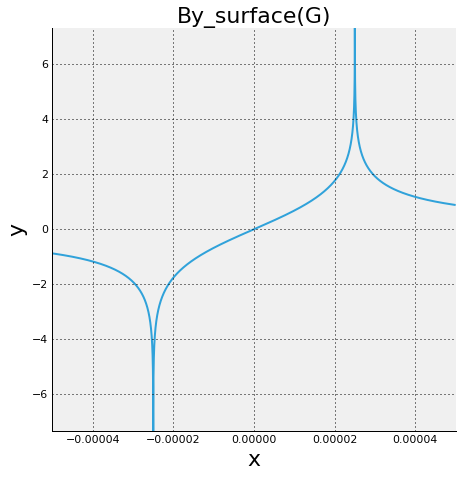

In [27]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 10000)
By = By_surface(x, w, d, j) * 1e4
hv.Curve((x, By), label='By_surface(G)')

### Linearly increases with current (or current density -- same thing if dimensions are fixed)

b':Curve   [I(mA)]   (Bmax(G))'
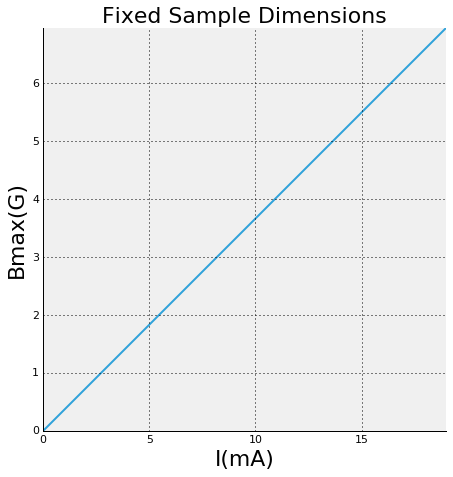

In [44]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 10000)
By = By_surface(x, w, d, j) * 1e4
I = np.arange(0, 20e-3, 1e-3)
max_Bs = np.array([max(By_surface(x, w, d, Ii/(w*d)) * 1e4) for Ii in I])
hv.Curve((I * 1e3, max_Bs), kdims=['I(mA)'], vdims=['Bmax(G)'], label='Fixed Sample Dimensions')

### Fix Current, Change Width

b':Curve   [Width(um)]   (Bmax(G))'
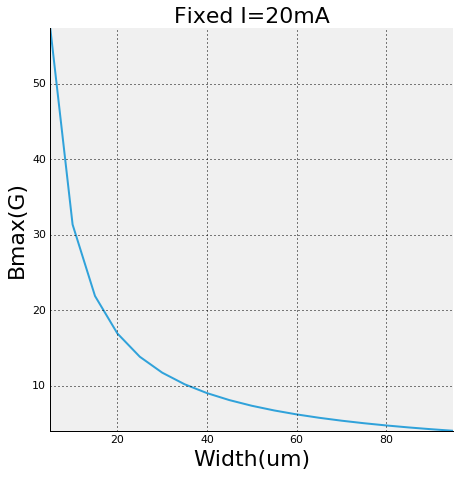

In [34]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 10000)
By = By_surface(x, w, d, j) * 1e4
hv.Curve((x, By), label='By_surface(G)')

w = np.arange(5e-6, 100e-6, 5e-6)
max_Bs = []
for wi in w:
    x = np.linspace(-wi, wi, 10000)
    max_Bs.append(max(By_surface(x, wi, d, I/(wi*d)) * 1e4))
    
hv.Curve((w * 1e6, max_Bs), kdims=['Width(um)'], vdims=['Bmax(G)'], label='Fixed I=20mA')

### Fix Current Density, Change Width

b':Curve   [Width(um)]   (Bmax(G))'
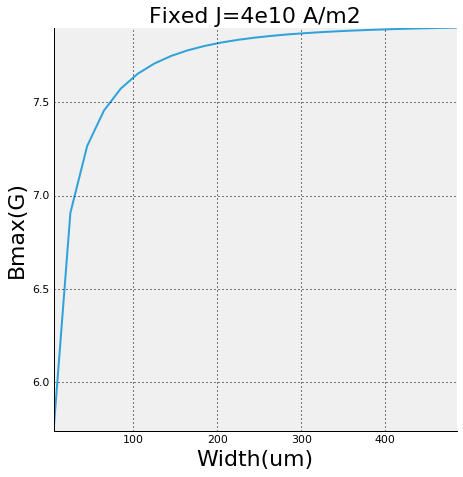

In [38]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 10000)
By = By_surface(x, w, d, j) * 1e4
hv.Curve((x, By), label='By_surface(G)')

w = np.arange(5e-6, 500e-6, 20e-6)
max_Bs = []
for wi in w:
    x = np.linspace(-wi, wi, 10000)
    max_Bs.append(max(By_surface(x, wi, d, j) * 1e4))
hv.Curve((w * 1e6, max_Bs), kdims=['Width(um)'], vdims=['Bmax(G)'], label='Fixed J=4e10 A/m2')

b':HoloMap   [Default]\n   :Curve   [x]   (y)'
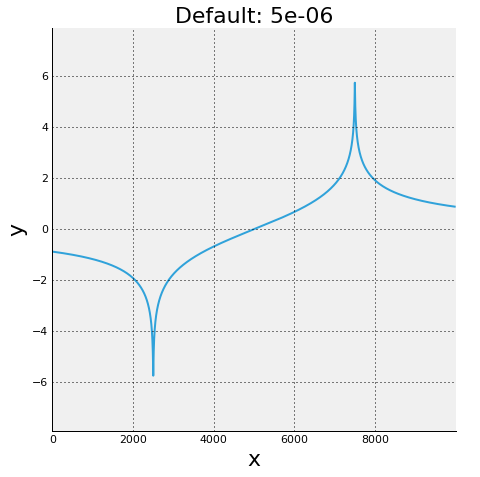
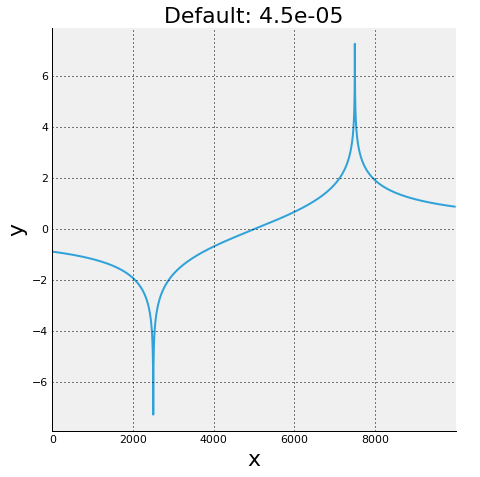
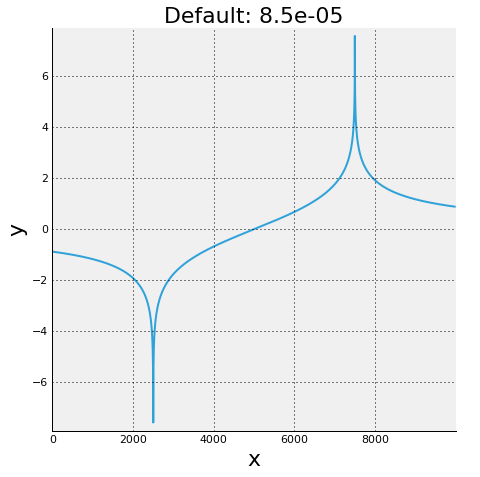
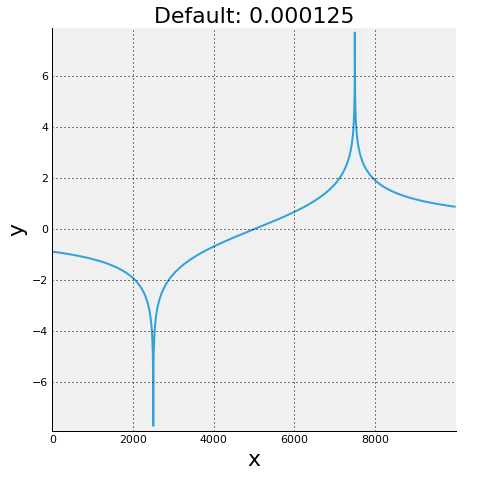
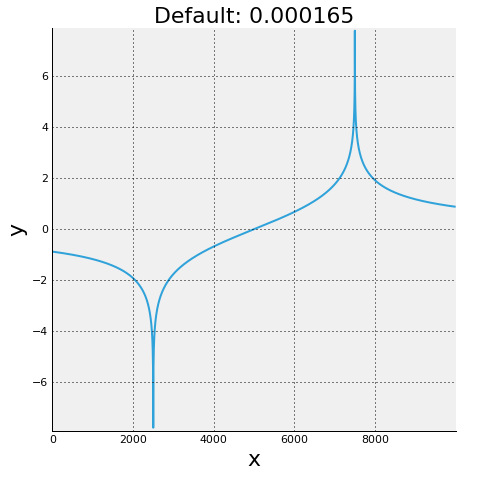
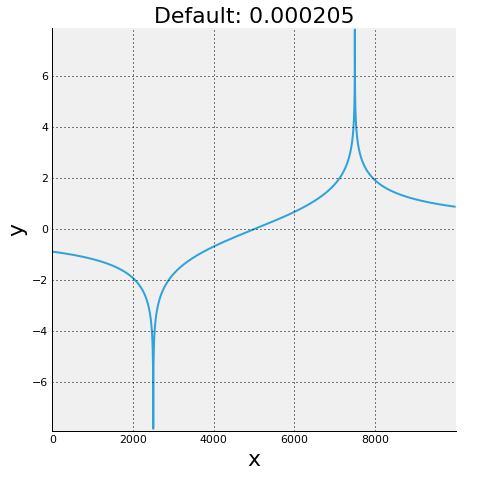
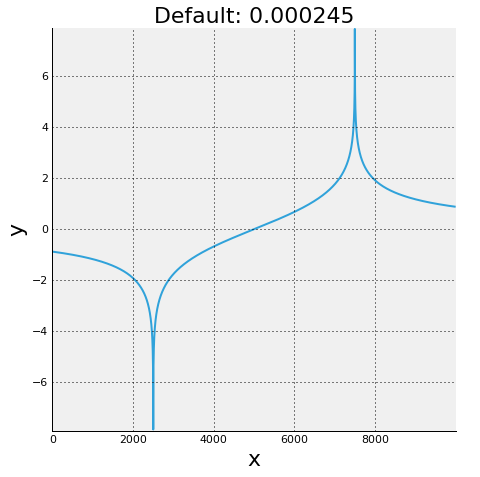
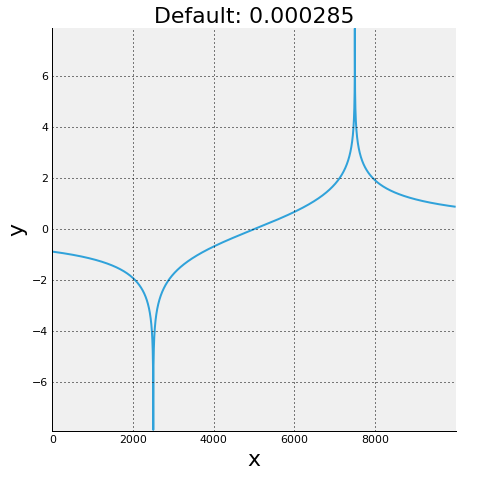
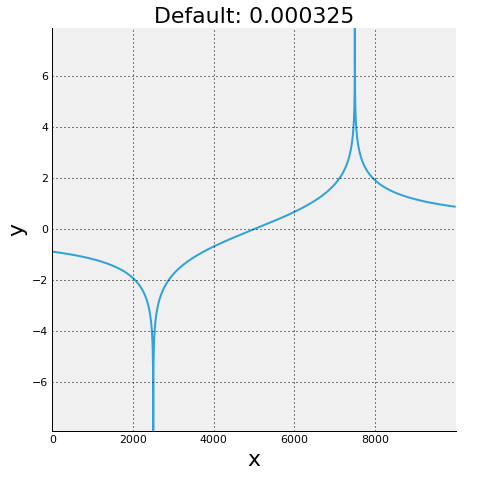
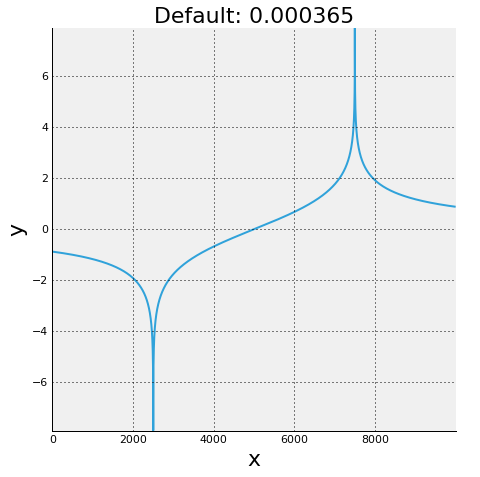
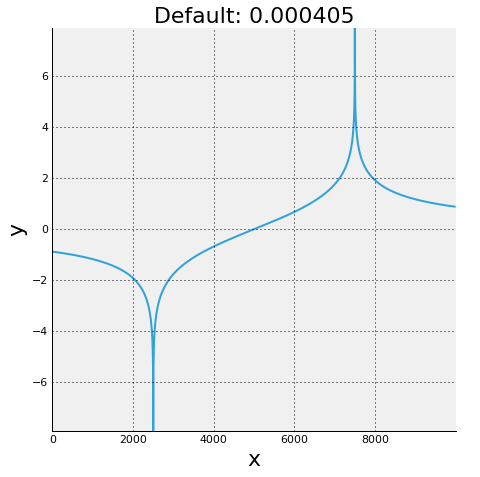
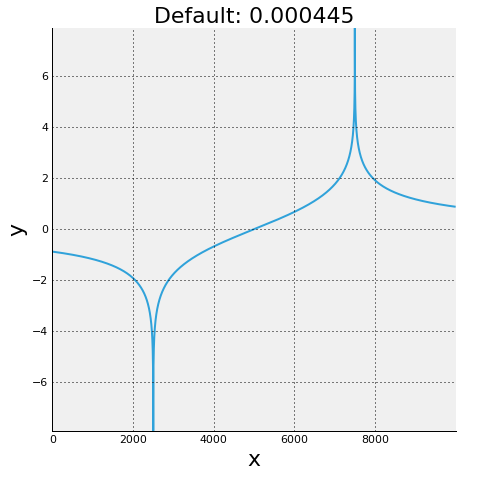
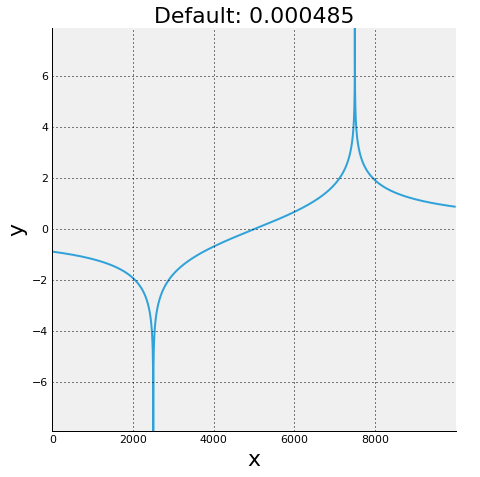

In [53]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 20000)
By = By_surface(x, w, d, j) * 1e4
hv.Curve((x, By), label='By_surface(G)')

w = np.arange(5e-6, 500e-6, 40e-6)
hmap_dict = {}
for wi in w:
    x = np.linspace(-wi, wi, 10000)
    hmap_dict[wi] = hv.Curve(By_surface(x, wi, d, j) * 1e4)
# hv.Curve((w * 1e6, max_Bs), kdims=['Width(um)'], vdims=['Bmax(G)'], label='Fixed J=4e10 A/m2')
hv.HoloMap(hmap_dict)

b':HoloMap   [Default]\n   :Curve   [x]   (y)'
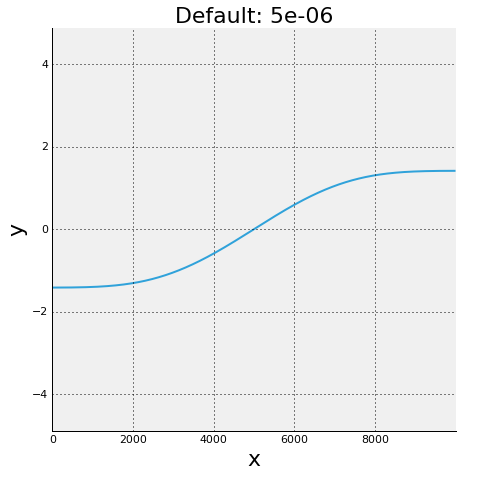
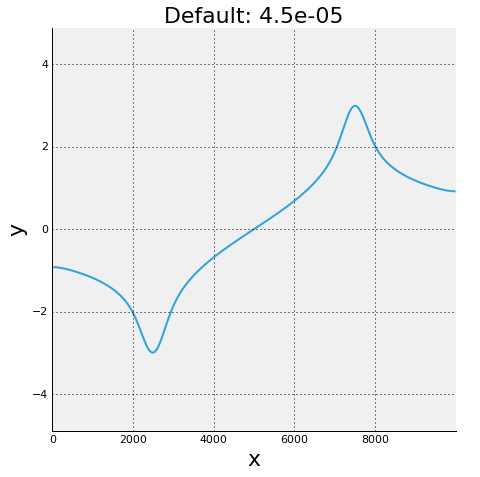
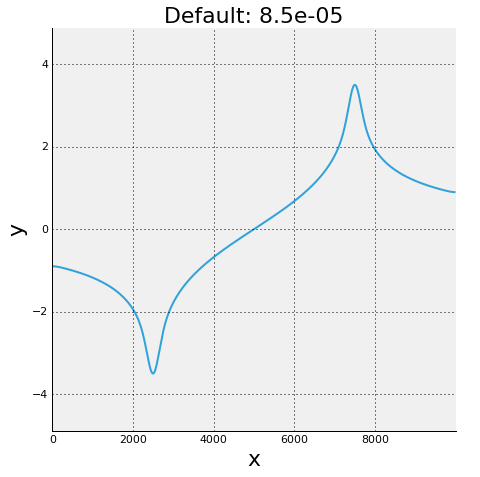
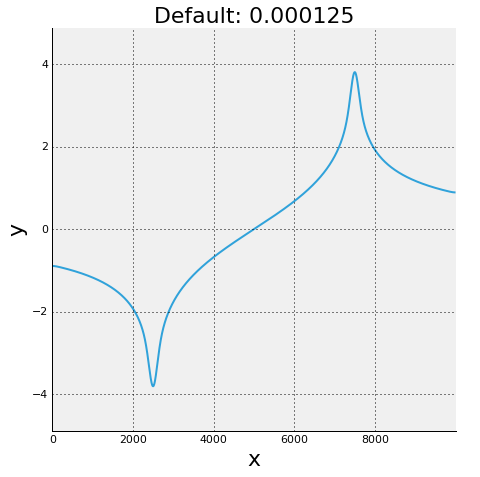
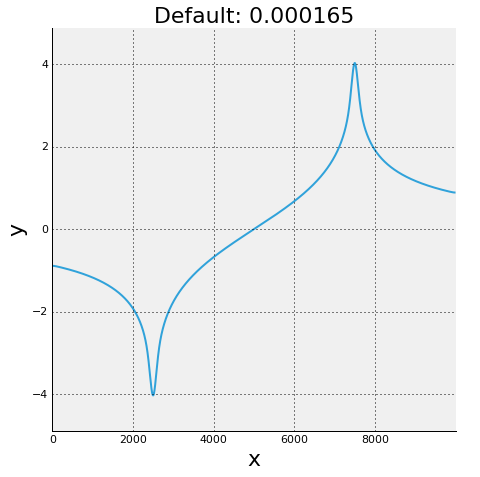
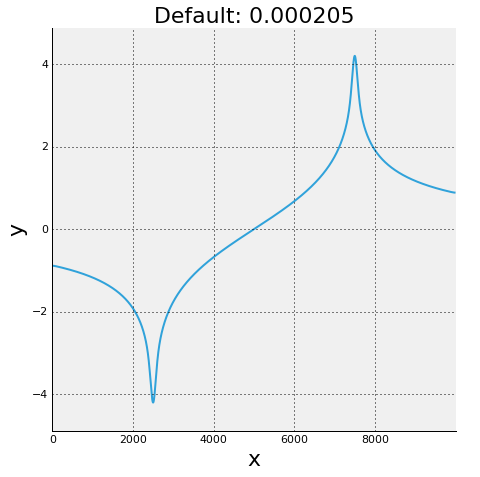
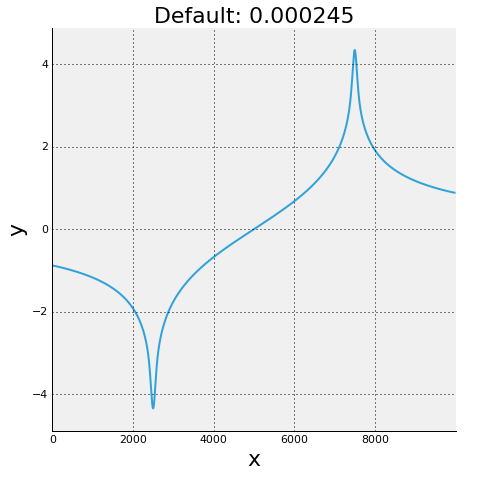
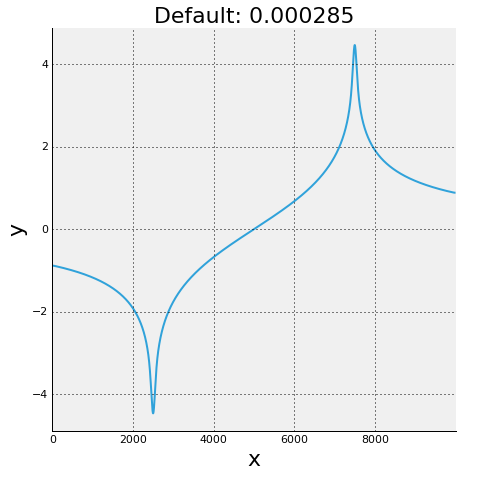
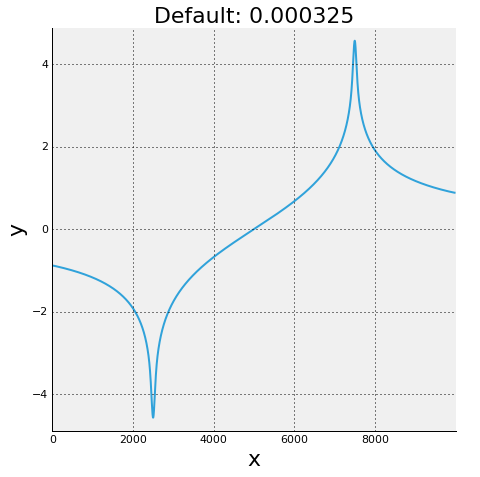
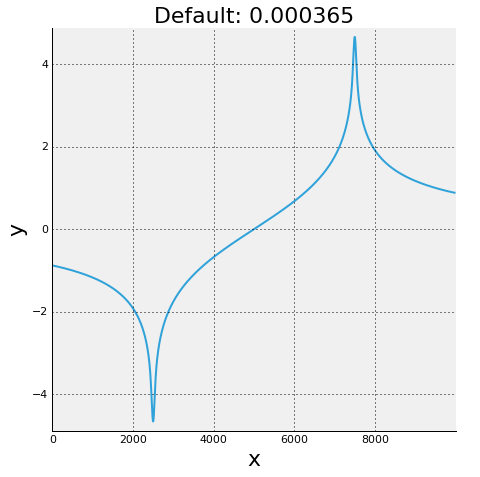
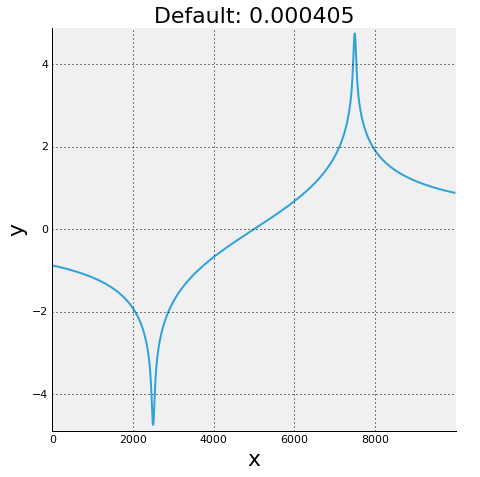
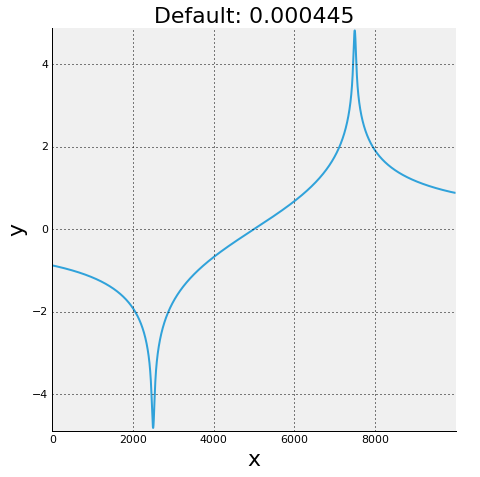
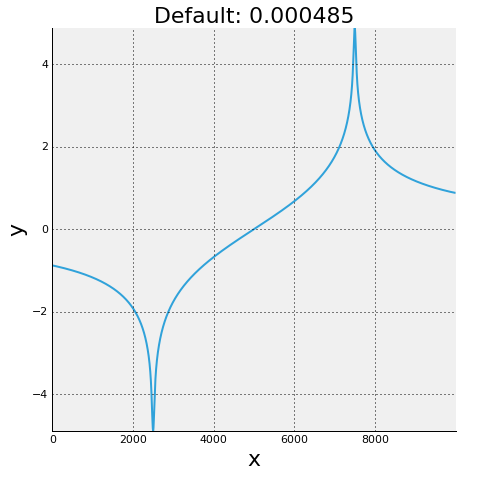

In [62]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)

x = np.linspace(-w, w, 20000)
By = By_surface(x, w, d, j) * 1e4
By = gf1d(By, 2.0e-6/(2*w) * 1e4)
hv.Curve((x, By), label='By_surface(G)')

w = np.arange(5e-6, 500e-6, 40e-6)
hmap_dict = {}
for wi in w:
    x = np.linspace(-wi, wi, 10000)
    sigma = 2.0e-6/(2*wi) * 1e4
    hmap_dict[wi] = hv.Curve(gf1d(By_surface(x, wi, d, j) * 1e4, sigma))
hv.HoloMap(hmap_dict)
# hv.Curve((w * 1e6, max_Bs), kdims=['Width(um)'], vdims=['Bmax(G)'], label='Fixed J=4e10 A/m2')


4.0

### Fix Current, change thickness

b':Curve   [Thickness(nm)]   (Bmax(G))'
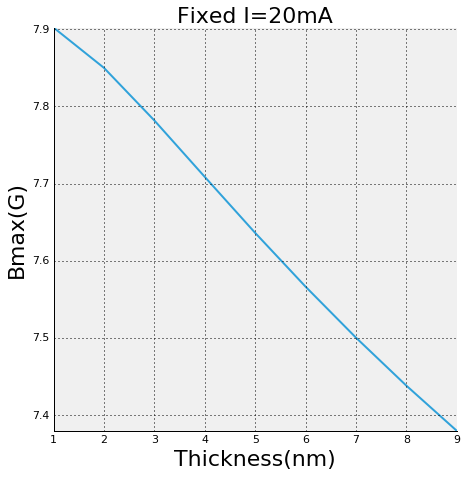

In [29]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)
x = np.linspace(-w, w, 10000)

d = np.arange(1e-9, 10e-9, 1e-9)
max_Bs = np.array([max(By_surface(x, w, di, I/(w*di)) * 1e4) for di in d])
hv.Curve((d * 1e9, max_Bs), kdims=['Thickness(nm)'], vdims=['Bmax(G)'], label='Fixed I=20mA')

b':Curve   [Thickness(nm)]   (Bmax(G))'
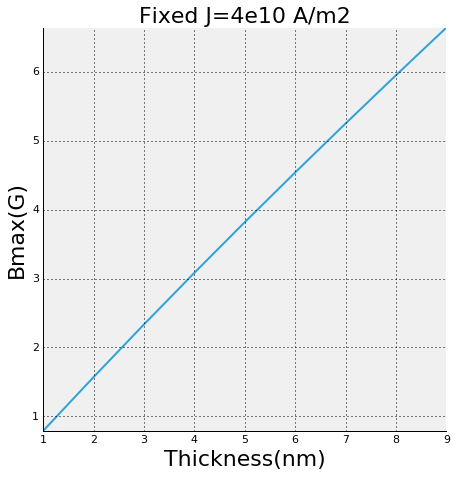

In [40]:
%%output size=200
%%opts Curve [fontsize=22]

w = 50e-6
d = 10e-9
I = 0.02
j = I / (w * d)
x = np.linspace(-w, w, 10000)

d = np.arange(1e-9, 10e-9, 1e-9)
max_Bs = np.array([max(By_surface(x, w, di, j) * 1e4) for di in d])
hv.Curve((d * 1e9, max_Bs), kdims=['Thickness(nm)'], vdims=['Bmax(G)'], label='Fixed J=4e10 A/m2')